<a href="https://colab.research.google.com/github/rzagni/Fintech/blob/main/rag_reranking_zagniA01795457.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**<font color="green">Fintech and Digital Innovation in Finance**</font>
###<font color="green">**Course project part 4 | Advanced RAG techniques & Sentiment Analysis on S&P 500 news**<font>
###<font color="green">**Renzo Zagni A01795457**</font>

# Introduction to reranking: an advanced RAG technique

In this notebook, you will test an advanced RAG technique: using a reranker (CrossEncoder model) to improve the retrieval of news in a RAG pipeline.

The notebook is partially filled with code. You will complete it by writing the missing code, running evaluations, and comparing results.

# 📌 Objectives

By the end of this notebook, students will be able to:

1. **Create and Use a Synthetic Evaluation Dataset:**
   - Automatically generate natural language questions corresponding to news articles using an LLM.
   - Construct a test set to assess the quality of retrieved answers.

2. **Evaluate Baseline RAG Performance Without Reranking:**
   - Measure how often the original article appears in the top-k results using FAISS alone.
   - Record retrieval accuracy and position for each query.

3. **Apply a Cross-Encoder Reranker to Improve Retrieval:**
   - Use a pretrained CrossEncoder model to rerank top FAISS results.
   - Evaluate improvements in the ranking of correct articles after reranking.

4. **Compare Retrieval Performance With and Without Reranking:**
   - Compute and visualize differences in rank positions before and after reranking.
   - Analyze statistical improvements (e.g., average rank, frequency at position 0).

5. **Reflect on the Impact of Reranking in RAG Pipelines:**
   - Discuss how reranking enhances retrieval quality in a RAG context.
   - Identify scenarios where reranking may offer the most value, and propose further improvements.


## Install and Import librairies
Run the following cell to install required libraries. These include `sentence-transformers` for embeddings and reranking, and `faiss-cpu` for vector similarity search.

In [ ]:
%pip install sentence-transformers
%pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from sentence_transformers import SentenceTransformer
import faiss
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
#
# Let's hide FutureWarnings...
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
#
# Additional libraries used
import os
import time
from tqdm import tqdm


In [ ]:
#
# Connect to G Drive to save and retrieve objects
from google.colab import drive
drive.mount('/content/drive')

working_dir = '/content/drive/MyDrive/MNA/Fintech/project4'

os.chdir(working_dir)
print(f"Working directory: {working_dir}")

Mounted at /content/drive
Working directory: /content/drive/MyDrive/MNA/Fintech/project4


## Load S&P 500 news
We will work with a dataset of financial news headlines and summaries. You will:
 - Load the data
 - Convert the publication date column to datetime
 - Drop duplicate summaries

In [ ]:
df_news = pd.read_csv('df_news.csv')
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE']).dt.date
display(df_news)
print(df_news.shape)

df_news.drop_duplicates('SUMMARY', inplace=True)
print(df_news.shape)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


(4871, 6)
(3976, 6)


## Implement a Faiss Vector Store with Sentence Transfomer embeddings
This section is already implemented. It uses a sentence transformer to encode news summaries into vector embeddings and stores them in a FAISS index.

We also define a simple class `FaissVectorStore` that allows for efficient retrieval.


In [ ]:
df_news['EMBEDDED_TEXT'] = df_news['TITLE'] + ' : ' + df_news['SUMMARY']

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Load model and compute embeddings
text_embeddings = model.encode(df_news['SUMMARY'].tolist(), convert_to_numpy=True)

# Normalize embeddings to use cosine similarity (via inner product in FAISS)
text_embeddings = text_embeddings / np.linalg.norm(text_embeddings, axis=1, keepdims=True)

# Prepare metadata
documents = df_news['SUMMARY'].tolist()
metadata = [
    {
        'PUBLICATION_DATE': row['PUBLICATION_DATE'],
        'TICKER': row['TICKER'],
        'PROVIDER': row['PROVIDER']
    }
    for _, row in df_news.iterrows()
]

In [ ]:
embedding_dim = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatIP(embedding_dim)  # Cosine similarity via inner product
faiss_index.add(text_embeddings)

In [ ]:
class FaissVectorStore:
    def __init__(self, model, index, embeddings, documents, metadata):
        self.model = model
        self.index = index
        self.embeddings = embeddings
        self.documents = documents
        self.metadata = metadata

    def search(self, query, k=5, metadata_filter=None):
        query_embedding = self.model.encode([query])
        query_embedding = query_embedding / np.linalg.norm(query_embedding)

        if metadata_filter:
            filtered_indices = [i for i, meta in enumerate(self.metadata) if metadata_filter(meta)]
            if not filtered_indices:
                return []
            filtered_embeddings = self.embeddings[filtered_indices]
            temp_index = faiss.IndexFlatIP(filtered_embeddings.shape[1])
            temp_index.add(filtered_embeddings)
            D, I = temp_index.search(query_embedding, k)
            indices = [filtered_indices[i] for i in I[0]]
        else:
            D, I = self.index.search(query_embedding, k)
            indices = I[0]
            D = D[0]

        results = []
        for idx, sim in zip(indices, D):
            results.append((self.documents[idx], self.metadata[idx], float(sim)))


        return results

In [ ]:
# Create FAISS-based store
faiss_store = FaissVectorStore(
    model=model,
    index=faiss_index,
    embeddings=text_embeddings,
    documents=documents,
    metadata=metadata
)

## Creating a dataset to evaluate the reranking

👉 **Instructions**:
- In this section, we will create an evaluation dataset for reranking by:
  - Sampling **100** distinct news articles from the full dataset.
  - Generating **one natural question** per article using GPT, where the expected answer is the original article.

✅ By the end of this section, you'll have a new DataFrame (`df_news_questions`) with:
- `NEWS`: the original summary
- `QUESTION`: the corresponding question generated using GPT

> ℹ️ The generated questions will simulate user queries in a RAG pipeline.

In [ ]:
#
# Let's sample 100 distinct news articles
# will not address potential duplicates since this
# was already taken care
df_news_sample = df_news.sample(n=100, random_state=42).reset_index(drop=True)

In [ ]:
display(df_news_sample.head(5))

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,EMBEDDED_TEXT
0,ANET,"Broadcom, Arista Networks initiated: Wall Stre...","Broadcom, Arista Networks initiated: Wall Stre...",2025-05-28,The Fly,https://finance.yahoo.com/news/broadcom-arista...,"Broadcom, Arista Networks initiated: Wall Stre..."
1,EMR,Investors Heavily Search Emerson Electric Co. ...,Emerson Electric (EMR) has received quite a bi...,2025-05-12,Zacks,https://finance.yahoo.com/news/investors-heavi...,Investors Heavily Search Emerson Electric Co. ...
2,BXP,Why Is Ventas (VTR) Down 2.1% Since Last Earni...,Ventas (VTR) reported earnings 30 days ago. Wh...,2025-05-30,Zacks,https://finance.yahoo.com/news/why-ventas-vtr-...,Why Is Ventas (VTR) Down 2.1% Since Last Earni...
3,QCOM,3 things Nvidia investors should look out for ...,Nvidia's earnings call this week will be a mar...,2025-05-28,Yahoo Finance,https://finance.yahoo.com/news/3-things-nvidia...,3 things Nvidia investors should look out for ...
4,KR,Inflation-weary Americans queue for toilet pap...,Inflation-scarred American consumers are putti...,2025-05-29,Financial Times,https://finance.yahoo.com/news/inflation-weary...,Inflation-weary Americans queue for toilet pap...


In [ ]:
print("Sample size:", df_news_sample.shape)

Sample size: (100, 7)


### Create OpenAI connector
You’ll use OpenAI’s GPT model to generate natural questions corresponding to each sampled news summary. These questions will be used to test the retrieval system.

✅ This cell contains an API key for demonstration purposes. You **must** use your own API key when running this notebook.


In [ ]:
from openai import OpenAI
client = OpenAI(api_key = "")

response = client.responses.create(
    model="gpt-4o-mini",
    input="Write a one-sentence bedtime story about a unicorn."
)

print(response.output_text)

As the stars twinkled above, the little unicorn spread her iridescent wings and soared into the night sky, bringing sweet dreams to every sleeping child below.


### Using GPT to generate a question based on a news
Based on the instruction above, you need to use GPT to create a evaluation dataset.

**Clarification** Specifically, the goal is to generate a natural question whose correct answer is the news summary. For example, if the news is about a company announcing layoffs, a good question could be: ‘Which company recently announced job cuts in its tech division?


In [ ]:
prompt = """
Given the news headline provided below,
give me a question that would justify retrieving this specific news headline in a RAG system

News headlines:
{news}

Give me a question for which the answer is the news headline:
QUESTION

**Important**
dont answer anything else other than the question!
"""

In [ ]:
def generate_question_from_news(news_text):
    formatted_prompt = prompt.format(news=news_text)

    try:
        response = client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "user", "content": formatted_prompt}
            ],
            temperature=0.7,
            max_tokens=80,
        )
        return response.choices[0].message.content.strip()

    except Exception as e:
        print("Error generating question:", e)
        return ""


In [ ]:

questions = []

for _, row in tqdm(df_news_sample.iterrows(), total=len(df_news_sample), desc="Generating questions"):
    headline = row['SUMMARY']
    question = generate_question_from_news(headline)

    questions.append({
        'NEWS': headline,
        'QUESTION': question
    })

    #
    # prevents rate limit issues
    time.sleep(1.2)

df_news_questions = pd.DataFrame(questions)
display(df_news_questions.head())

Generating questions: 100%|██████████| 100/100 [03:42<00:00,  2.23s/it]


,NEWS,QUESTION
0,"Broadcom, Arista Networks initiated: Wall Stre...",What recent analyst calls have been made regar...
1,Emerson Electric (EMR) has received quite a bi...,What recent attention has Emerson Electric (EM...
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent developments and future earnings e...
3,Nvidia's earnings call this week will be a mar...,What are the key points to watch for in Nvidia...
4,Inflation-scarred American consumers are putti...,What are the current shopping behaviors of inf...


## Evaluating RAG without and with reranking

You will now compare a basic RAG pipeline using FAISS with an enhanced version that includes reranking.


### RAG without reranking

👉 **Instructions**:
1. Implement a function that retrieves the **top 5** news summaries for a given question using your FAISS vector store.
2. For each `(QUESTION, NEWS)` pair:
   - Search using the `QUESTION`
   - Check if the corresponding `NEWS` appears in the top 5 retrieved summaries.
   - Record the **rank position** (from 0 to 4) in a new column `NO_RERANKER`.
   - If the news is **not found**, store `'not found'`.

✅ This step helps measure the baseline performance of your vector-based retrieval without reranking.

> 💡 Tip: You can store the retrieved results in a dictionary or list to avoid recomputation.

In [ ]:
#
# define function for reusability
def get_top_n_news(question, vector_store, n=5):
    """
    Retrieve the top n news summaries from a FAISS vector store for a question.

    Parameters:
        question (str)
        vector_store (FaissVectorStore)
        n (int): Number of top results to retrieve (default is 5).

    Returns:
        List[str]: A list of the top n retrieved news summaries.
    """
    results = vector_store.search(query=question, k=n)
    top_summaries = [doc for doc, _, _ in results]
    return top_summaries

In [ ]:
#
# Add column NO_RERANKER to dataframe. Set default value to 'not found'
df_news_questions['NO_RERANKER'] = 'not found'

In [ ]:
#
# Let's iterate thru all the questions , retrieve the top 5 and see if there is
# match
for index, row in df_news_questions.iterrows():
    question = row['QUESTION']
    news = row['NEWS']

    top_5_news = get_top_n_news(question, faiss_store, 5)
    if news in top_5_news:
         df_news_questions.at[index, 'NO_RERANKER'] = top_5_news.index(news)


In [ ]:
display(df_news_questions)

,NEWS,QUESTION,NO_RERANKER
0,"Broadcom, Arista Networks initiated: Wall Stre...",What recent analyst calls have been made regar...,0
1,Emerson Electric (EMR) has received quite a bi...,What recent attention has Emerson Electric (EM...,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent developments and future earnings e...,0
3,Nvidia's earnings call this week will be a mar...,What are the key points to watch for in Nvidia...,0
4,Inflation-scarred American consumers are putti...,What are the current shopping behaviors of inf...,0
...,...,...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...,What were the key financial results for T. Row...,0
96,"Heartland Advisors, an investment management c...",What were the key highlights from Heartland Ad...,0
97,Key Insights Given the large stake in the stoc...,What are the potential implications of institu...,0
98,The study found that early intervention led to...,What were the findings of the study regarding ...,0


In [ ]:
#
# Let's see what different rankings we obtained
print(df_news_questions['NO_RERANKER'].value_counts())

NO_RERANKER
0            89
1             4
not found     4
3             2
2             1
Name: count, dtype: int64


In [ ]:
#
# Let's investigate what happened with the 4 news that did not get a match
not_found_rows = df_news_questions[df_news_questions['NO_RERANKER'] == 'not found']
display(not_found_rows)

,NEWS,QUESTION,NO_RERANKER
27,"CF Industries, Mosaic and Yara International h...",Which companies are mentioned in the Industry ...,not found
50,"NetEase, Fox, Qifu Technology and UGI make the...",Which companies are identified as strong divid...,not found
79,(Bloomberg) -- The stock market’s crazy first ...,What has been the impact of the stock market's...,not found
94,(Bloomberg) -- Connected TV advertising platfo...,What significant event recently occurred invol...,not found


In [ ]:
#
# Let's pick one question, news pair and retrive the top 10
# From the output below , we can see the news are not ranked
# within the top 5 hence we don't find a match.
sample_question = not_found_rows['QUESTION'].iloc[0]
sample_news = not_found_rows['NEWS'].iloc[0]
print(sample_news)
top10 = get_top_n_news(sample_question, faiss_store, n=10)
print("Top 10 retrieved summaries:")
for i, summary in enumerate(top10, 1):
    print(f"{i}. {summary}\n")

CF Industries, Mosaic and Yara International have been highlighted in this Industry Outlook article.
Top 5 retrieved summaries:
1. Berkshire Hathaway, The Progressive, Chubb, The Travelers Companies and The Allstate have been highlighted in this Industry Outlook article.

2. Companies in The News Are: DIS, UBER, EMR, GOOGL, AAPL

3. Companies in The News Are: A, VEEV, HPQ, BMA

4. MetLife, American International, Principal Financial, Everest and Assurant have been highlighted in this Industry Outlook article.

5. Eaton, Emerson Electric, EnerSys and Powell Industries are part of the Zacks Industry Outlook article.

6. CF Industries, Mosaic and Yara International have been highlighted in this Industry Outlook article.

7. Companies in The News Are: BX,KEY,SCHW,RF

8. Companies In The Article Are:BAC, C, PNC, PNFP

9. Cardinal Health, Labcorp and Align Technology have been highlighted in this Industry Outlook article.

10. Consolidated Edison, DTE, CenterPoint Energy and Evergy have been

### RAG with reranking
In this section, you will add reranking using a cross-encoder model (`ms-marco-MiniLM-L12-v2`) to improve retrieval.

👉 **Instructions**:
1. Retrieve the **top 100** summaries from FAISS for each question.
2. Rerank these summaries using the CrossEncoder model: `cross-encoder/ms-marco-MiniLM-L12-v2`.
For each question, retrieve the top-100 summaries from FAISS, then rerank only those 100 using the CrossEncoder model.
3. Return the **top 5** reranked results.
4. For each `(QUESTION, NEWS)` pair, record the new rank (0–4) of the correct news in a new column: `WITH_RERANKER`.
5. Again, if the news is not found, store `'not found'`.

✅ This step lets you evaluate how much the reranker improves the relevance of retrieved results.

> ℹ️ The CrossEncoder scores each (question, summary) pair individually, so this step may take longer to run.



In [ ]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L12-v2')
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
print(scores)

[ 9.218913  -4.0780296]


In [ ]:
#
# Add column WITH_RERANKER to dataframe. Set default value to 'not found'
df_news_questions['WITH_RERANKER'] = 'not found'

In [ ]:
#
# Let's iterate thru all the questions , retrieve the top 5 and see if there is
# match
for index, row in df_news_questions.iterrows():
    question = row['QUESTION']
    news = row['NEWS']

    top_100_news = get_top_n_news(question, faiss_store, 100)
    input_pairs = [(question, summary) for summary in top_100_news]
    scores = model.predict(input_pairs)
    reranked = sorted(zip(top_100_news, scores), key=lambda x: x[1], reverse=True)
    top_5_news_reranked = [summary for summary, score in reranked[:5]]
    if news in top_5_news_reranked:
         df_news_questions.at[index, 'WITH_RERANKER'] = top_5_news_reranked.index(news)

In [ ]:
print(df_news_questions['WITH_RERANKER'].value_counts())

WITH_RERANKER
0            93
1             3
3             2
2             1
not found     1
Name: count, dtype: int64


In [ ]:
#
# Let's investigate what happened with the news that did not get a match
not_found_rows = df_news_questions[df_news_questions['WITH_RERANKER'] == 'not found']
display(not_found_rows)

,NEWS,QUESTION,NO_RERANKER,WITH_RERANKER
94,(Bloomberg) -- Connected TV advertising platfo...,What significant event recently occurred invol...,not found,not found


In [ ]:
#
# Let's find out how far down the list was the news ranked
sample_question = not_found_rows['QUESTION'].iloc[0]
sample_news = not_found_rows['NEWS'].iloc[0]
print(f'News not found: {sample_news[:80]}...')
top200 = get_top_n_news(sample_question, faiss_store, n=184)
if sample_news in top200:
    position = top200.index(sample_news)
    print(f'Found the news in the position {position} the top 200 (no rerank)')


News not found: (Bloomberg) -- Connected TV advertising platform MNTN Inc.’s shares climbed 65% ...
Found the news in the position 183 the top 200 (no rerank)


## Comparison and analysis

👉 **Instructions**:
- Analyze the impact of reranking using your results.
- Write short answers to the following:
  1. Did reranking improve the **average position** of the correct news?
  2. How often was the correct article at **position 0** with and without reranking?
- You may use:
  - Value counts (`.value_counts()`)
  - Descriptive statistics (`.mean()`, `.median()`)
  - Simple plots (e.g. bar charts or histograms)

✅ This is your opportunity to reflect on the performance of the reranker and think critically about retrieval quality.

> ✨ Optional: You can create a summary table comparing the overall accuracy and coverage between the two methods.

In [ ]:
df_evaluation = df_news_questions.copy()
#
# Let's update the dataframe cells that are set to 'not found' with the number 5
df_evaluation['NO_RERANKER_NUM'] = df_evaluation['NO_RERANKER'].replace('not found', 5).astype(int)
df_evaluation['WITH_RERANKER_NUM'] = df_evaluation['WITH_RERANKER'].replace('not found', 5).astype(int)


In [ ]:
df_evaluation

,NEWS,QUESTION,NO_RERANKER,WITH_RERANKER,NO_RERANKER_NUM,WITH_RERANKER_NUM
0,"Broadcom, Arista Networks initiated: Wall Stre...",What recent analyst calls have been made regar...,0,0,0,0
1,Emerson Electric (EMR) has received quite a bi...,What recent attention has Emerson Electric (EM...,0,0,0,0
2,Ventas (VTR) reported earnings 30 days ago. Wh...,What recent developments and future earnings e...,0,0,0,0
3,Nvidia's earnings call this week will be a mar...,What are the key points to watch for in Nvidia...,0,0,0,0
4,Inflation-scarred American consumers are putti...,What are the current shopping behaviors of inf...,0,0,0,0
...,...,...,...,...,...,...
95,T. Rowe Price Group ( NASDAQ:TROW ) First Quar...,What were the key financial results for T. Row...,0,0,0,0
96,"Heartland Advisors, an investment management c...",What were the key highlights from Heartland Ad...,0,0,0,0
97,Key Insights Given the large stake in the stoc...,What are the potential implications of institu...,0,0,0,0
98,The study found that early intervention led to...,What were the findings of the study regarding ...,0,0,0,0


In [ ]:
#
# Let's calculate the mean and standard deviation to compare performance
no_rerank_mean = df_evaluation['NO_RERANKER_NUM'].mean()
no_rerank_std = df_evaluation['NO_RERANKER_NUM'].std()

rerank_mean = df_evaluation['WITH_RERANKER_NUM'].mean()
rerank_std = df_evaluation['WITH_RERANKER_NUM'].std()

print(f"Average position (no reranker): {no_rerank_mean:.2f} ± {no_rerank_std:.2f}")
print(f"Average position (with reranker): {rerank_mean:.2f} ± {rerank_std:.2f}")


Average position (no reranker): 0.32 ± 1.08
Average position (with reranker): 0.16 ± 0.69


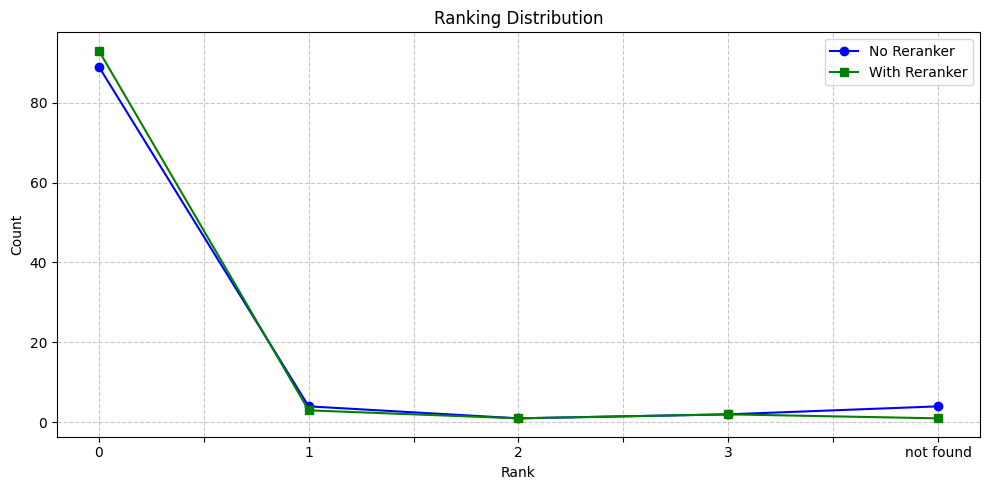

In [ ]:
#
# For better visualization let's plot the ranking results
plot_df = df_news_questions.copy()
plot_df['NO_RERANKER'] = plot_df['NO_RERANKER'].astype(str)
plot_df['WITH_RERANKER'] = plot_df['WITH_RERANKER'].astype(str)

no_rerank_counts = plot_df['NO_RERANKER'].value_counts().sort_index()
rerank_counts = plot_df['WITH_RERANKER'].value_counts().sort_index()

all_positions = sorted(set(no_rerank_counts.index).union(set(rerank_counts.index)))
no_rerank_counts = no_rerank_counts.reindex(all_positions, fill_value=0)
rerank_counts = rerank_counts.reindex(all_positions, fill_value=0)

fig, ax = plt.subplots(figsize=(10, 5))
no_rerank_counts.plot(kind='line', marker='o', label='No Reranker', color='blue')
rerank_counts.plot(kind='line', marker='s', label='With Reranker', color='green')

plt.title('Ranking Distribution')
plt.xlabel('Rank')
plt.ylabel('Count')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


### **Question 1.** Did reranking improve the **average position** of the correct news?


<font color="green">Yes, reranking improved the average position of the correct news. The mean rank position decreased from 0.32 before reranking to 0.16 after applying the reranker. Since lower values indicate that the correct item is retrieved closer to the top of the results list, this shows that reranking made it easier for the system to place the right news item in a more prominent position. In practice, this means users would more often find the correct result without having to scan far down the list.

<font color="green">On the other hand, the standard deviation also dropped from 1.08 to 0.69. This matters because it shows that reranking not only improved the average rank but also reduced variability across queries. In other words, the system became more consistent: it was less likely to make large mistakes where the correct news appeared much further down in the ranking.

<font color="green">Taken together, these results show that reranking contributed both to accuracy and reliability. The correct news was positioned closer to the top more often, and the performance was steadier across different questions. This suggests that the reranker helped create a retrieval process that is not only more effective but also more predictable for users.</font>


### **Question 2.** How often was the correct article at **position 0** with and without reranking?


<font color="green">The correct article was retrieved at position 0 in 89 out of 100 cases without reranking, and in 93 out of 100 cases after reranking. This means that reranking improved the system’s ability to place the right article at the very top of the results list, increasing accuracy by 4 percentage points. While the improvement may seem small, it is meaningful because it reflects a higher likelihood that users immediately see the correct answer without needing to search down the ranked list.</font>

<font color="green">It is also important to note that retrieval using FAISS alone was already strong, since the correct article was found at position 0 in the majority of cases. However, reranking with the cross-encoder built on this solid baseline and pushed performance a little further, ensuring that the most relevant article was surfaced first more often. This demonstrates the value of reranking as a refinement step where even when the base retriever is performing well, reranking helps fine-tune the order of results to better match relevance.</font>